# Vizzuality Challenge, ETL pipeline.

This notebook shows the detailed process of a pipeline that extracts the total carbon for each county from the National Forest Carbon Monitoring System (see Readme.txt for specifications on download.py).

 This ETL pipeline will: 

- 1 - Download the necesary data (download.py)

- 2 - Select the ROI (Every county of the states of Michigan, Wisconsin and Minnesota) within the USA administrative boundaries Shapefile source

- 3 - Summarize Total Ecosystem Carbon for the set ROI. TotalExosystemCarbon_2020 is the chosen raster due that is the "current" state of carbon ecosystem data in the region. 

- 4 - Convert according to necesity CRSs, units, etc. 

- 5 - Create a .gpkg file with a new column containing Total Ecosystem Carbon values for each county

- 6 - Upload it to a relational database for inquires 

- 7 - Simple vizzualization of the output data. 


In [114]:
from pathlib import Path
import requests, zipfile
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterstats import zonal_stats
import pandas as pd
import numpy as np
import warnings
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterio.enums import Resampling

# Base directories.
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"
RAW = DATA_DIR / "raw"
PROCESSED = DATA_DIR / "processed"
OUTPUT = DATA_DIR / "output"

for folder in [RAW, PROCESSED, OUTPUT]:
    folder.mkdir(parents=True, exist_ok=True)

print("Folders are ready:", list(DATA_DIR.glob('*')))

Folders are ready: [WindowsPath('d:/Vizzuality_challenge/data/.gitkeep'), WindowsPath('d:/Vizzuality_challenge/data/output'), WindowsPath('d:/Vizzuality_challenge/data/processed'), WindowsPath('d:/Vizzuality_challenge/data/raw')]


## Data extraction
Raster downloaded from the National Forest Carbon Monitoring System. 
The shapefiles are downloaded from United States Census bureau (2025). 
Due to the size of the raster, if the file is already downloaded, it will skip it. 


In [118]:
# Data download, quick import from download.py file. You can also execute .py file directly if wanted.
# This module is added to the notebook for the intent of traceability. 

from download import download_and_extract

# Downloads
counties_dir = download_and_extract(COUNTIES_URL, RAW)
carbon_dir = download_and_extract(CARBON_URL, RAW)

# Find paths after download
shp_path = list(counties_dir.rglob("*.shp"))[0]
raster_path = next(carbon_dir.rglob("*.tif"))
print("Download completed.")


Skipping: tl_2025_us_county already exists with content.
Skipping: v861gwms9fq68sitl0r3vs2v3moxeu9x already exists with content.
Download completed.


## Pre-processing
Clip region of interest (MI, WI, MN)

In [89]:
# County filtering 

gdf = gpd.read_file(shp_path)

filtered = gdf[gdf["STATEFP"].isin(["26", "27", "55"])].copy() # Michigan (26), Minnesota (27), Wisconsin (55). 
filtered_path = PROCESSED / "counties_MI_WI_MN.gpkg" # Change to gpkg for file consistency
filtered.to_file(filtered_path, driver="GPKG")

print(f"Geopackage saved in: {filtered_path}")
print("County count", len(filtered))

Geopackage saved in: d:\Vizzuality_challenge\data\processed\counties_MI_WI_MN.gpkg
County count 242


CRS reprojection 

In [ ]:
# Obtains CRS from .gpkg, equals it to raster file and defines route to be used by Zonal Stats. 

print("\nRaster & counties correction")
print("Original raster path:", raster_path)

with rasterio.open(raster_path) as src:
    raster_crs = src.crs
    
    # 1. Reproyects de .gpkg file to equal rasters CRS. 
    gdf_reproj = gpd.read_file(filtered_path).to_crs(raster_crs)
    
    # 2. Saves the reproyected .pgpk for future use
    filtered_path_reproj = PROCESSED / "counties_reproj.gpkg"
    gdf_reproj.to_file(filtered_path_reproj, driver="GPKG")
    
    clipped_raster = raster_path # Due to RAM limitations...  

print(f"New Geopackage saved in: {filtered_path_reproj}")



Raster & counties correction
Original raster path: d:\Vizzuality_challenge\data\raw\v861gwms9fq68sitl0r3vs2v3moxeu9x\Data\NLS\NLS_AbovegroundBiomass2020.tif
New Geopackage saved in: d:\Vizzuality_challenge\data\processed\counties_reproj.gpkg


## Data preview 
Quick preview of raster and ROI 


Raster summary:
  • CRS: EPSG:5070
  • Native Resolution: (30.0, 30.0)
  • Dimensions: 41,498 × 30,934
  • NoData value: 65535


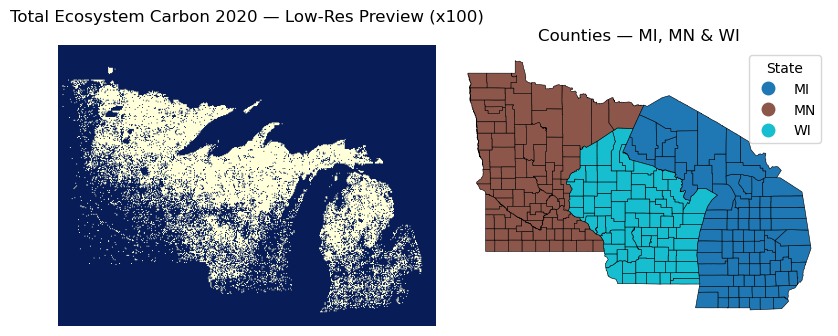

In [112]:
from rasterio.enums import Resampling
from rasterio.transform import array_bounds 

DOWNSCALE = 100

with rasterio.open(clipped_raster) as src:
    # Metadata summary
    crs = src.crs
    res = src.res
    nodata_val = src.nodata
    width, height = src.width, src.height
    
    print("\nRaster summary:")
    print(f"  • CRS: {crs}")
    print(f"  • Native Resolution: {res}")
    print(f"  • Dimensions: {width:,} × {height:,}")
    print(f"  • NoData value: 65535")
    
    # Read and downsample raster
    lowres = src.read(
        1,
        out_shape=(int(src.height/DOWNSCALE), int(src.width/DOWNSCALE)),
        resampling=Resampling.nearest
    )

    # Compute extent
    transform = src.transform * src.transform.scale(
        src.width / lowres.shape[1],
        src.height / lowres.shape[0]
    )
    bounds = array_bounds(lowres.shape[0], lowres.shape[1], transform)

    # Prepare abbreviations
state_map = {"26": "MI", "27": "MN", "55": "WI"}
filtered["STATE_ABBR"] = filtered["STATEFP"].map(state_map)

# Combined plot
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Left: Raster
img = axes[0].imshow(
    lowres,
    extent=(bounds[0], bounds[2], bounds[1], bounds[3]),
    cmap=cmap,
    origin="upper"
)
axes[0].set_title(f"Total Ecosystem Carbon 2020 — Low-Res Preview (x{DOWNSCALE})", fontsize=12)
axes[0].set_axis_off()

# Right: Counties
filtered.plot(
    ax=axes[1],
    column="STATE_ABBR",
    categorical=True,
    legend=True,
    cmap="tab10",
    edgecolor="black",
    linewidth=0.4
)
axes[1].set_title("Counties — MI, MN & WI", fontsize=12)
axes[1].set_axis_off()

# Legend styling
leg = axes[1].get_legend()
if leg:
    leg.set_title("State")

plt.tight_layout()
plt.show()




## Zonal stats processing

Original raster's units where in Mg CO₂e/acre (a density unit), our interest is to summarize the total carbon in each county, so we will need to convert this units to what we need (Mg C per pixel) then we just sum all the pixels within each county and create a column in the output geopackage. 

Original raster's NoData value is 65535, so we will make sure we correctly identify it. To avoid misshandling of NoData from Numpy, we will change the array to a floating type. (Fix to the error I was receiving)

Finally, Zone Stats grabs each pixel that geographically correspond to the county, and sums up all of them. Kept the density values for reference. 

The geopackage output brings a lot of columns we're not interested for the current analysis, so i will delete them. 

In [ ]:
# Raster units conversion, Zonal stats, and output export (~ 1min, 30secs)

print("\nCalculating total carbon per county...")

# Converts Units in original raster Mg CO₂e/acre to Mg C/pixel. Needed to Sum Total Carbon per county. 

# FACTOR = (Mg CO₂e/acre to Mg C/pixel)
FACTOR = (900 / 4046.86) * (12 / 44) 
NODATA_ORIGINAL = 65535 # Raster's Nodata value
MAX_VALUE = 173 # Maximum clipping value used in the original analysis. Just a error check point.

def sum_cleaned_raw(a):
    """Sum raw pixels (Mg CO₂e/acre) after NoData cleaning and clipping."""
    
    # FIX: Convert to float32 to allow np.nan and perform float calculations
    a = a.astype(np.float32) 
    
    # 1. Cleaning
    a[a == NODATA_ORIGINAL] = np.nan # Apply NoData
    a[a > MAX_VALUE] = np.nan        # Removes inflated values if they exist. 
    
    # 2. Total sum of clean raw values
    return np.nansum(a)

def count_valid_pixels(a):
    """Count the number of valid pixels after cleaning."""
    # Just another checkpoint, had some trouble "Relying" on output values. 
    a = a.astype(np.float32) 
    a[a == NODATA_ORIGINAL] = np.nan
    a[a > MAX_VALUE] = np.nan
    return np.nansum(np.isfinite(a))


# Reads reprojected polygons
gdf = gpd.read_file(filtered_path_reproj) 

# ---- ZONAL STATISTICS -----
print(" Converting units and running zonal stats...")

# Temporarily suppress rasterstats warnings due to nodata in custom stats. had some
# issues with noData values, found this way to prevent it from processing data.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    stats = zonal_stats(
        vectors=gdf,
        raster=str(clipped_raster), # Use path to ORIGINAL raster
        stats=[], 
        add_stats={'raw_sum_CO2e_acre': sum_cleaned_raw, 'valid_pixels': count_valid_pixels},
        geojson_out=False,
        nodata=NODATA_ORIGINAL, 
        all_touched=False
    )

# Add columns
gdf["raw_sum_CO2e_acre"] = [s["raw_sum_CO2e_acre"] for s in stats]
gdf["valid_pixels"] = [s["valid_pixels"] for s in stats]

# Conversion of units to Mg C
print("Applying conversion factor (Mg CO₂e/acre to Mg C)...")
gdf["total_MgC"] = gdf["raw_sum_CO2e_acre"] * FACTOR

# Removes columns we don't use/want
columns_to_drop = [
    "COUNTYNS", "GEOIDFQ", "LSAD", "MTFCC", "CSAFP","CBSAFP","CLASSFP", 
    "METDIVFP", "FUNCSTAT", "ALAND", "AWATER", "INTPTLAT", "INTPTLON"
]

# Only drop columns that actually exist (one more check-point for errors)
gdf = gdf.drop(columns=[c for c in columns_to_drop if c in gdf.columns])

print(f"Dropped columns: {[c for c in columns_to_drop if c not in gdf.columns]}")

# --- Step 5: Export result ---
out_gpkg = OUTPUT / "carbon_total_by_county.gpkg"
gdf.to_file(out_gpkg, driver="GPKG")

print(f"\nGeoPackage saved in: {out_gpkg}")
print("\nPreview of results:")
print(gdf[["NAME", "raw_sum_CO2e_acre", "valid_pixels", "total_MgC"]].head())
print(f"\n Process completed successfully. Total counties processed: {len(gdf)}")




Calculating total carbon per county...
 Converting units and running zonal stats...
Applying conversion factor (Mg CO₂e/acre to Mg C)...
🧹 Dropped columns: ['COUNTYNS', 'GEOIDFQ', 'LSAD', 'MTFCC', 'CBSAFP', 'CLASSFP', 'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']

GeoPackage saved in: data\output\carbon_total_by_county.gpkg

Preview of results:
         NAME  raw_sum_CO2e_acre  valid_pixels     total_MgC
0    Richland         80253840.0        908127  4.867643e+06
1       Grant          4373964.0         67423  2.652944e+05
2  Green Lake         18854288.0        275296  1.143571e+06
3    Walworth         25412840.0        317963  1.541367e+06
4       Eaton         35590720.0        440851  2.158687e+06

 Process completed successfully. Total counties processed: 242


## Output Vizzualization

After Zonal Stats we can plot a gradual simbology to visually detect the counties with higher total MgC

With SQLite queries we will be able to find more detailed information about our output...

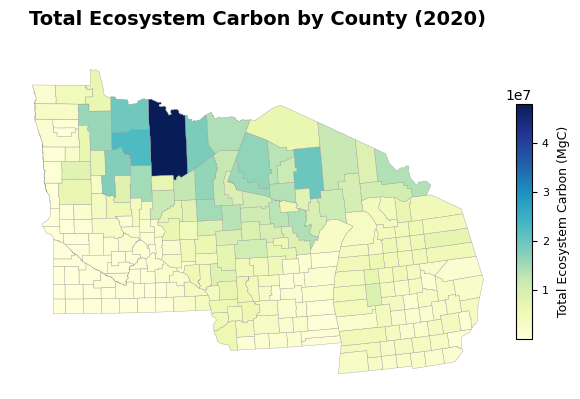

In [ ]:
gdf = gpd.read_file(OUTPUT / "carbon_total_by_county.gpkg")

# Figure
fig, ax = plt.subplots(figsize=(6, 4))

# Plot (no auto-legend)
cmap = "YlGnBu"
gdf.plot(
    ax=ax,
    column="total_MgC",
    cmap=cmap,
    legend=False,        # we'll add our own colorbar
    edgecolor="0.6",
    linewidth=0.25
)

# Create a SMALL colorbar from the mappable collection
mappable = ax.collections[0]                    # first collection is the map
cbar = plt.colorbar(
    mappable,
    ax=ax,
    fraction=0.03,       # thinner bar
    pad=0.02,            # closer to the map
    aspect=15            # longer vs width (increase for thinner look)
)
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Total Ecosystem Carbon (MgC)", fontsize=9, labelpad=6)

# Style
ax.set_title("Total Ecosystem Carbon by County (2020)", fontsize=14, weight="bold", pad=10)
ax.set_axis_off()
ax.set_facecolor("white")

# Layout (no tight_layout so our manual sizes stay put)
plt.subplots_adjust(right=0.92, left=0.05, top=0.92, bottom=0.02)
plt.show()

## Data base

SQLite doesn’t require a server and can be shared as a single .db file, so I think is ideal for quick analysis and reproducibility...

In [ ]:
import sqlite3
import pandas as pd

db_path = "data/output/total_carbon.db"

# Connect to SQLite
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Shows the tables containd in the db. 
print("Tables in database:")
tables = cursor.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
for t in tables:
    print(" -", t[0])

# grabs the column info for the main table
print("\nTable structure for 'total_carbon':")
columns = cursor.execute("PRAGMA table_info(total_carbon);").fetchall()
for col in columns:
    print(f" - {col[1]} ({col[2]})")

# Previews the first few rows
print("\n Data preview:")
df_preview = pd.read_sql("SELECT * FROM total_carbon LIMIT 5;", conn)
print(df_preview)

conn.close()

Tables in database:
 - total_carbon

Table structure for 'total_carbon':
 - STATEFP (TEXT)
 - COUNTYFP (TEXT)
 - GEOID (TEXT)
 - NAME (TEXT)
 - NAMELSAD (TEXT)
 - CSAFP (TEXT)
 - raw_sum_CO2e_acre (REAL)
 - valid_pixels (INTEGER)
 - total_MgC (REAL)

 Data preview:
  STATEFP COUNTYFP  GEOID        NAME           NAMELSAD CSAFP  \
0      55      103  55103    Richland    Richland County  None   
1      27      051  27051       Grant       Grant County  None   
2      55      047  55047  Green Lake  Green Lake County  None   
3      55      127  55127    Walworth    Walworth County   376   
4      26      045  26045       Eaton       Eaton County   330   

   raw_sum_CO2e_acre  valid_pixels     total_MgC  
0         80253840.0        908127  4.867643e+06  
1          4373964.0         67423  2.652944e+05  
2         18854288.0        275296  1.143571e+06  
3         25412840.0        317963  1.541367e+06  
4         35590720.0        440851  2.158687e+06  


## SQLite queries
- 1 - Open connection
- 2 - Execute queries

In [ ]:
db_path = "data/output/total_carbon.db"
 # conn = sqlite3.connect(db_path)  # opens connection
 # conn.close () # Closes connection after queries are solved. 

Example of queries to do on the database.

In [ ]:
# Counties with the most Carbon in all three states 
conn = sqlite3.connect(db_path)

top3 = pd.read_sql("""
SELECT NAME, STATEFP, total_MgC
FROM total_carbon
ORDER BY total_MgC DESC
LIMIT 3;
""", conn)

# Counties with the less amount of carbon in all three states
bottom3 = pd.read_sql("""
SELECT NAME, STATEFP, total_MgC
FROM total_carbon
WHERE total_MgC IS NOT NULL
ORDER BY total_MgC ASC
LIMIT 3;
""", conn)

conn.close()


We can plot them for a more visual analysis...

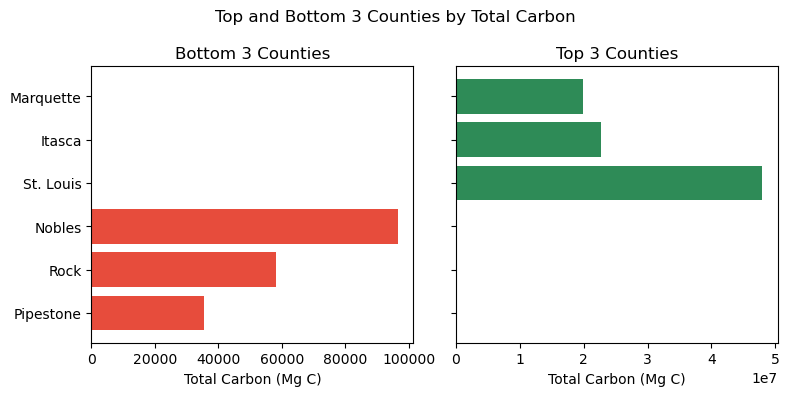

In [111]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# Left: bottom 3
axes[0].barh(bottom3["NAME"], bottom3["total_MgC"], color="#E74C3C")
axes[0].set_title("Bottom 3 Counties")
axes[0].set_xlabel("Total Carbon (Mg C)")

# Right: top 3
axes[1].barh(top3["NAME"], top3["total_MgC"], color="#2E8B57")
axes[1].set_title("Top 3 Counties")
axes[1].set_xlabel("Total Carbon (Mg C)")

for ax in axes:
    ax.invert_yaxis()

plt.suptitle("Top and Bottom 3 Counties by Total Carbon")
plt.tight_layout()
plt.show()


We can also compare the total carbon of each state

In [49]:
conn = sqlite3.connect(db_path)

carbon_total = pd.read_sql("""
SELECT STATEFP,
       SUM(total_MgC) AS total_MgC
FROM total_carbon
GROUP BY STATEFP
ORDER BY total_MgC DESC;
""", conn)

conn.close()

And plot it aswell... A pie chart is a very efficient way to do this comparission


Total carbon per state (Mg C):
  STATEFP     total_MgC State
0      26  4.388581e+08    MI
1      55  3.868102e+08    WI
2      27  3.199132e+08    MN


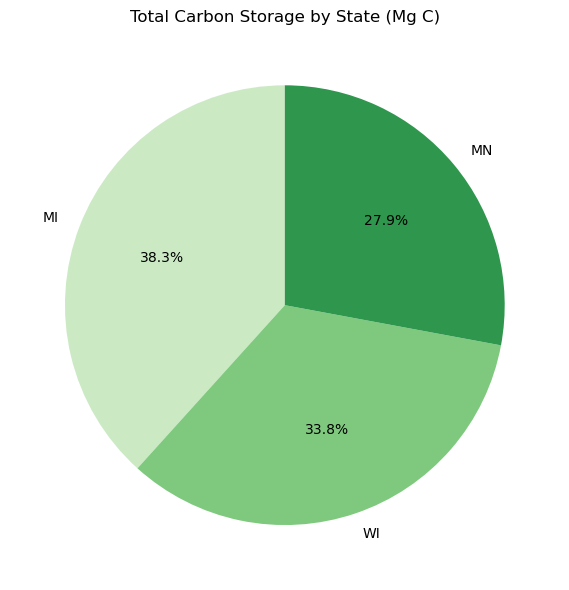

In [50]:
# --- Replace FIPS codes with state abbreviations ---
fips_to_state = {
    "26": "MI",  # Michigan
    "27": "MN",  # Minnesota
    "55": "WI"   # Wisconsin
}
carbon_total["State"] = carbon_total["STATEFP"].map(fips_to_state)

print("\nTotal carbon per state (Mg C):")
print(carbon_total)

# --- Plot: Pie chart of total carbon ---
plt.figure(figsize=(6, 6))
plt.pie(
    carbon_total["total_MgC"],
    labels=carbon_total["State"],
    autopct="%1.1f%%",
    startangle=90,
    colors=plt.cm.Greens(range(60, 240, 60))
)

plt.title("Total Carbon Storage by State (Mg C)")
plt.tight_layout()
plt.show()